## Import data and libraries

In [1]:
import polars as pl
import datetime as dt
%run utils.ipynb

In [2]:

dfs_dict=load_data("out_paths",backup="polars")

In [3]:
dos_df=dfs_dict["dos_df"]
fuzzy_df=dfs_dict["fuzzy_df"]
attack_free_df=dfs_dict["attack_free_df"]
dfs = [dos_df, fuzzy_df, attack_free_df]

## Data Preprocesssing

#### Column Names

In [4]:
existing_timestamp_column_name = "timestamp"
existing_can_id_column_name = "can_id"
existing_dlc_column_name="dlc"


new_timestamp_column_name = "datetime"
new_can_id_column_name = "can_id"
new_message_column_name="message"

### Convert Data Types

In [5]:
def validate_column_in_dataframe(df, column_name):
    """
    Checks column exist or not in given df.

    Parameters
    ----------
    df :pl.DataFrame
        Input DataFrame.
    column_name : str
        Column name that will be checked.

    Raises
    ------
    ValueError
       If the specified column does not exist in the DataFrame.
    """

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

#### Timestamp

In [6]:
def convert_timestamp_to_datetime(df, new_column_name, existing_column_name):
    """
    Convert float timestamp column into datetime and add as new column.

    Parameters
    ----------
    data : pl.DataFrame
        Input DataFrame containing the timestamp column.
    new_column_name : str
        Name of new column to be added.
    existing_column_name : str
        Name of the existing column containing timestamps.

    Returns
    -------
    pl.DataFrame
        DataFrame with newly added datetime column.

    Raises
    ------
    ValueError
        If the existing column is not found in the DataFrame.
    """

    validate_column_in_dataframe(df, existing_column_name)

    return df.with_columns(
        pl.from_epoch(pl.col(existing_column_name), time_unit="s").alias(
            new_column_name
        )
    )

In [7]:
def convert_multiple_dfs_timestamp_to_datetime(
    dfs, new_column_name, existing_column_name
):
    """
    Convert multiple dfs' timestamp column into datetime column.

    Parameters
    ----------
    dfs : list
        List of DataFrame.
    new_column_name : str
        Name of new column to be added
    existing_column_name : str
        Name of the existing column containing timestamps.

    Returns
    -------
    list
        List of updated DataFrame.
    """
    return [
        convert_timestamp_to_datetime(df, new_column_name, 
                                      existing_column_name)
        for df in dfs
    ]

In [8]:
converted_timestamp_dfs = convert_multiple_dfs_timestamp_to_datetime(
    dfs, new_timestamp_column_name, existing_timestamp_column_name
)
dos_df, fuzzy_df, attack_free_df = converted_timestamp_dfs

#### can_id

In [9]:
def convert_hex_column_to_int(df,new_column_name,existing_column_name):
    """
    Convert hex that it's dtype is str into int column.

    Parameters
    ----------
    df : pl.DataFrame
        Input DataFrame containing the hex column.
    new_column_name : str
        Name of new column to be added.
    existing_column_name : str
        Name of the existing column containing hex.

    Returns
    -------
    pl.DataFrame
        DataFrame with newly added hex int column.

    Raises
    ------
    ValueError
        If the existing column is not found in the DataFrame.
    """

    validate_column_in_dataframe(df, existing_column_name)

    return df.with_columns(pl.col(existing_column_name).str.to_integer(base=16, strict=True).alias(new_column_name))

In [10]:
def convert_multiple_dfs_str_hex_can_id_to_int(dfs, new_column_name, existing_column_name):
    """
    Convert multiple dfs' str hex column into int hex column.

    Parameters
    ----------
    dfs : list
        List of DataFrame.
    new_column_name : str
        Name of new column to be added
    existing_column_name : str
        Name of the existing column containing hex.

    Returns
    -------
    list
        List of updated DataFrame.
    """
    return [
        convert_hex_column_to_int(df,new_column_name,existing_column_name)
        for df in dfs
    ]


In [11]:
converted_can_id_dfs = convert_multiple_dfs_str_hex_can_id_to_int(
    converted_timestamp_dfs, new_can_id_column_name, existing_can_id_column_name
)
dos_df, fuzzy_df, attack_free_df = converted_can_id_dfs

#### Bytes

In [12]:
def convert_bytes_to_int(df,existing_byte_column_names,new_byte_column_names):
    """
    Convert byte columns in hexadecimal format to integer columns.

    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame containing the byte columns.
    existing_byte_column_names : list of str
        List of names of the existing byte columns in hexadecimal format.
    new_byte_column_names : list of str
        List of names for the new columns to store the converted integer values.

    Returns
    -------
    pl.DataFrame
        A DataFrame with the newly added integer columns corresponding to the byte columns.

    Raises
    ------
    ValueError
        If the lengths of `existing_byte_column_names` and `new_byte_column_names` do not match.
    """
    
    if len(existing_byte_column_names) != len(new_byte_column_names):
            raise ValueError("The lengths of existing_column_names and new_column_names must match.")

    column_names_dict = dict(zip(existing_byte_column_names, new_byte_column_names))
    for existing_byte_column_name, new_byte_column_name in column_names_dict.items():
        df = df.with_columns(pl.col(existing_byte_column_name).str.to_integer(base=16, strict=True).alias(new_byte_column_name))
    return df
    
    


In [13]:
dfs=[dos_df, fuzzy_df, attack_free_df]
max_dlc_number=max([df[existing_dlc_column_name].max() for df in dfs])
existing_byte_column_names=[f"byte_{i}"for i in range(max_dlc_number)]
new_byte_column_names=[f"byte_{i}"for i in range(max_dlc_number)]

In [14]:
def convert_multiple_dfs_bytes_to_int(dfs,existing_column_names,new_column_names):
    """
    Convert byte columns in hexadecimal format to integer columns for multiple DataFrames.

    This function applies the `convert_bytes_to_int` function to a list of DataFrames, 
    transforming specified byte columns in hexadecimal format into integer columns.

    Parameters
    ----------
    dfs : list of pl.DataFrame
        A list of DataFrames, each containing the byte columns to be converted.
    existing_column_names : list of str
        List of names of the existing byte columns in each DataFrame.
    new_column_names : list of str
        List of names for the new columns to store the converted integer values in each DataFrame.

    Returns
    -------
    list of pl.DataFrame
        A list of DataFrames with the newly added integer columns corresponding to the byte columns.

    Raises
    ------
    ValueError
        If the lengths of `existing_column_names` and `new_column_names` do not match.
    """
    return [
        convert_bytes_to_int(df,existing_column_names,new_column_names)
        for df in dfs
    ]

In [15]:
converted_bytes_dfs =  convert_multiple_dfs_bytes_to_int(
    [dos_df,fuzzy_df,attack_free_df], existing_byte_column_names, new_byte_column_names
)
dos_df, fuzzy_df, attack_free_df = converted_bytes_dfs

In [16]:
dos_df.head()

timestamp,can_id,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,updated_flag,datetime
f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,datetime[μs]
1.4782e9,399,8,254,91,0,0,0,60,0,0,"""R""",2016-11-03 18:39:36
1.4782e9,608,8,25,33,34,48,8,142,109,58,"""R""",2016-11-03 18:39:36
1.4782e9,672,8,100,0,154,29,151,2,189,0,"""R""",2016-11-03 18:39:36
1.4782e9,809,8,64,187,127,20,17,32,0,20,"""R""",2016-11-03 18:39:36
1.4782e9,1349,8,216,0,0,138,0,0,0,0,"""R""",2016-11-03 18:39:36


### Add New Features

#### Bytes to Message

In [17]:
def merge_byte_columns(df,existing_column_name,new_column_name):
    """
    Combine byte0...byte7 columns that represent message parts to one column which directly name is message.

    Parameters
    ----------
    df : pl.DataFrame
        Input DataFrame containing the byte columns.
    new_column_name : str
        Name of new column to be added.
    existing_column_name : str
        Name of the existing column containing dlc.
    Returns
    -------
    pl.DataFrame
        DataFrame with newly added message str column.
    """

    return df.with_columns(
        pl.concat_str([f"byte_{i}"for i in range(df[existing_column_name].max())],ignore_nulls=True).
        alias(new_column_name))


In [18]:
def merge_multiple_dfs_bytes_to_message_column(dfs,existing_column_name,new_column_name):
    """
    Combine byte columns from multiple DataFrames into a new message column.
   
    Parameters
    ----------
    dfs : list
        List of DataFrame.
    new_column_name : str
        Name of new column to be added 
    existing_column_name : str
        Name of the existing column containing dlc.

    Returns
    -------
    list
        List of updated DataFrame.
    """
    return [
        merge_byte_columns(df,existing_column_name,new_column_name)
        for df in dfs
    ]


In [19]:
# added_message_dfs = merge_multiple_dfs_bytes_to_message_column(
#     converted_bytes_dfs, existing_dlc_column_name,new_message_column_name
# )
# dos_df, fuzzy_df, attack_free_df = added_message_dfs

#### updated_flag to Attack_Free

In [20]:
def add_updated_flag_column_to_attack_free(df):
    """
    Adds an 'updated_flag' column to the attack-free DataFrame, assigning 'R'(representing a normal message) to all rows.

    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame to which the 'updated_flag' column will be added.

    Returns
    -------
    pl.DataFrame
        DataFrame with newly added updated_flag str column.
    """
    updated_flag=pl.Series('updated_flag',["R"]*len(df))
    return df.with_columns(updated_flag)


In [21]:
attack_free_df=add_updated_flag_column_to_attack_free(attack_free_df)
attack_free_df.head()

timestamp,can_id,frame_type,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,datetime,updated_flag
f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],str
1.4791e9,848,0,8,5,40,132,102,109,0,0,162,2016-11-14 11:03:54,"""R"""
1.4791e9,704,0,8,20,0,0,0,0,0,0,0,2016-11-14 11:03:54,"""R"""
1.4791e9,1072,0,8,0,0,0,0,0,0,0,0,2016-11-14 11:03:54,"""R"""
1.4791e9,1201,0,8,0,0,0,0,0,0,0,0,2016-11-14 11:03:54,"""R"""
1.4791e9,497,0,8,0,0,0,0,0,0,0,0,2016-11-14 11:03:54,"""R"""


### Delete Some Features

#### frame_type in Attack-Free

In [22]:
attack_free_df["frame_type"].unique()

frame_type
i64
0


 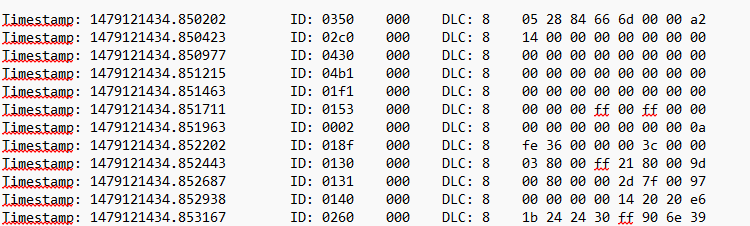

- During the conversion of `attack_free.txt` to a CSV file, I noticed an unnamed column, initially assumed it could represent the frame type and added it as such. 
- However, since its values are all `0` and its purpose is unclear, we decided to remove it from the DataFrame to avoid unnecessary clutter.
- You can see an example of this column in the above image.

In [23]:

def get_byte_column_names(dfs, dlc_column):
    max_dlc_value = max([df[dlc_column].max() for df in dfs])
    return [f"byte_{i}" for i in range(max_dlc_value)]


In [24]:
def drop_columns(df,columns_to_delete):
    """
    Drop multiple columns from DataFrame
    
    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame to which the columns_to_delete will be deleted.

    Returns
    -------
    pl.DataFrame
        DataFrame with newly deleted columns.
    """
    return df.drop(columns_to_delete)



In [25]:
attack_free_df=drop_columns(attack_free_df,["frame_type"])

In [26]:
print(dos_df.columns)
print(fuzzy_df.columns)
print(attack_free_df.columns)

['timestamp', 'can_id', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'updated_flag', 'datetime']
['timestamp', 'can_id', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'updated_flag', 'datetime']
['timestamp', 'can_id', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'datetime', 'updated_flag']


### Swap Features

In [27]:
def swap_features_in_specific_order(dfs,specific_order):
    """
    Reorders the features (columns) of each DataFrame in the input list to match a specific order.

    Parameters
    ----------
    dfs : list of pl.DataFrame
        A list of DataFrame objects whose columns need to be reordered.
    specific_order : list of str
        A list specifying the desired column order

    Returns
    -------
    list
        A list of DataFrames, each with columns reordered to match the `specific_order`.
    """
    return [
    df.select(specific_order)
    for df in dfs
    ]

In [28]:
specific_order = (
        ["can_id", "timestamp", "datetime", "dlc"]
        + [f"byte_{i}" for i in range(max_dlc_number)]
        + ["updated_flag"]
    )
dos_df,fuzzy_df,attack_free_df=swap_features_in_specific_order([dos_df,fuzzy_df,attack_free_df],specific_order)

In [29]:
print(dos_df.columns)
print(fuzzy_df.columns)
print(attack_free_df.columns)

['can_id', 'timestamp', 'datetime', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'updated_flag']
['can_id', 'timestamp', 'datetime', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'updated_flag']
['can_id', 'timestamp', 'datetime', 'dlc', 'byte_0', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'updated_flag']


### Encode Some Features

#### Flag

In [30]:
def encode_updated_flag_column(df, existing_flag_column_name):
    """
    Encode the updated flag column where 'R' represents normal messages (0) 
    and 'T' represents injected messages (1).

    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame.
    existing_flag_column_name : str
        Name of the column to be encoded.

    Returns
    -------
    pl.DataFrame
        DataFrame with the encoded flag column.
    """
    return df.with_columns(
        #r=normal,t=injected
        pl.when(pl.col(existing_flag_column_name) == 'R')
        .then(0)
        .when(pl.col(existing_flag_column_name) == 'T')
        .then(1)
        .otherwise(-1)  # Fallback for unexpected values
        .alias(existing_flag_column_name)
    )



In [31]:
def encode_multiple_dfs_updated_flag_column(dfs,existing_column_name):
    """
    Encode the updated flag column in multiple DataFrames.

    This function applies the `encode_updated_flag_column` method to a list of DataFrames, 
    encoding the specified column where 'R' represents normal messages (0) and 'T' 
    represents injected messages (1).

    Parameters
    ----------
    dfs : list of pl.DataFrame
        A list of input DataFrames containing the column to be encoded.
    existing_column_name : str
        The name of the column to encode in each DataFrame.

    Returns
    -------
    list of pl.DataFrame
        A list of DataFrames with the specified column encoded.
    """
    return [
    encode_updated_flag_column(df, existing_column_name)
    for df in dfs
    ]

In [32]:
dos_df,fuzzy_df,attack_free_df=encode_multiple_dfs_updated_flag_column([dos_df,fuzzy_df,attack_free_df],"updated_flag")

In [33]:
dos_df.head()

can_id,timestamp,datetime,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,updated_flag
i64,f64,datetime[μs],i64,i64,i64,i64,i64,i64,i64,i64,i64,i32
399,1.4782e9,2016-11-03 18:39:36,8,254,91,0,0,0,60,0,0,0
608,1.4782e9,2016-11-03 18:39:36,8,25,33,34,48,8,142,109,58,0
672,1.4782e9,2016-11-03 18:39:36,8,100,0,154,29,151,2,189,0,0
809,1.4782e9,2016-11-03 18:39:36,8,64,187,127,20,17,32,0,20,0
1349,1.4782e9,2016-11-03 18:39:36,8,216,0,0,138,0,0,0,0,0


In [34]:
fuzzy_df.head()

can_id,timestamp,datetime,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,updated_flag
i64,f64,datetime[μs],i64,i64,i64,i64,i64,i64,i64,i64,i64,i32
688,1.4782e9,2016-11-03 17:55:21,5,255,127,0,5,73,null,null,null,0
2,1.4782e9,2016-11-03 17:55:21,8,0,0,0,0,0,1,7,21,0
339,1.4782e9,2016-11-03 17:55:21,8,0,33,16,255,0,255,0,0,0
304,1.4782e9,2016-11-03 17:55:21,8,25,128,0,255,254,127,7,96,0
305,1.4782e9,2016-11-03 17:55:21,8,23,128,0,0,101,127,7,159,0


In [35]:
attack_free_df.head()

can_id,timestamp,datetime,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,updated_flag
i64,f64,datetime[μs],i64,i64,i64,i64,i64,i64,i64,i64,i64,i32
848,1.4791e9,2016-11-14 11:03:54,8,5,40,132,102,109,0,0,162,0
704,1.4791e9,2016-11-14 11:03:54,8,20,0,0,0,0,0,0,0,0
1072,1.4791e9,2016-11-14 11:03:54,8,0,0,0,0,0,0,0,0,0
1201,1.4791e9,2016-11-14 11:03:54,8,0,0,0,0,0,0,0,0,0
497,1.4791e9,2016-11-14 11:03:54,8,0,0,0,0,0,0,0,0,0


#### Datetime

In [36]:
dos_df["datetime"].dtype

Datetime(time_unit='us', time_zone=None)